# More cleanup and fine-tuning of tests.
V.12: cleanup of v11, also moving to volume-weighted size distributions. 
V.13: Using an excel file input to set up the tests and test groups. Considering daemon functions... 
V.14: tests using Martin's coils. Not much fine-tuning remaining. 

Use with Anaconda3-4.4.0 env. 


SPONGE: the brute-force scattering pattern simulator for any 3D structure. 
======

Introduction
--

The SPONGE will calculate the theoretical scattering pattern for any 3D structure using the Debye equation for point-pairs. The structure to be used is defined using the common STereo Lithography (STL) format, the standard for describing structures in 3D for FDM printers. 

STL describes only the tesselated surface of a volumetric object, and is available as an output format for most 3D drawing software packages. Its common nature means that structures can be easily drawn by the researcher using their favourite 3D drawing tool, after which this code can simulate the scattering pattern. The disadvantage of the format is that "colours" are not strictly supported, and so objects with components of varying scattering contrast cannot be described. The second disadvantage of STL is that no units are specified, and so we here assume that 1 STL unit is 1 nm. 

The underlying code uses the Debye equation, as defined in 1915 by P. Debye (doi: 10.1002/andp.19153510606). This is one of the most fundamental scattering equations, and is commonly used to describe the scattering from arrangements of spherical objects, for example for scattering pattern simulation of proteins or amorphous structures. Strictly speaking, however, finite dimensions of the constituent spherical objects are not required, and the equation can be generalized for distributions of infinitisimally small points within an object. 

The Debye equation for single point-pair-distances $d$ (in nm) is given as:

$I(q) = 4 \pi V \int^\infty_0 \frac{\sin(qd)}{qd} \mathrm{d}d$

with $I(q)$ the scattering intensity, V the volume of the object, $q$ the scattering vector in reciprocal nm. 

The Python implementation heavily relies on the provision of the Visualization Toolkit (VTK: Schroeder, Will; Martin, Ken; Lorensen, Bill (2006), The Visualization Toolkit (4th ed.), Kitware, ISBN 978-1-930934-19-1) library. This is an extensive open-source software system for 3D graphics, and contains the functions required to interpret the STL format, and to determine for a distribution of points in 3D space, whether the points lie inside or outside of the closed hull defined by the surface. With this functionality, we can obtain a set of randomly distributed points that lie within the object within a reasonable timeframe. 

Uncertainties on the simulated data are estimated through generation of a number of independent repetitions. The datapoints at the same $q$-value in these repetitions are averaged, and a standard error on the mean is then used as the uncertainty estimate. 

Accuracy of the simulation can be affected by two parameters: the number of points within the object, and the number of repetitions. A higher number of repetitions will increase the accuracy of the simulation, and, given their independent nature, incidentally allow for a high degree of parallelisation in the computation. Increasing the number of points within the object will improve the high-$q$ region of the simulated data (as more point-pairs are available with shorter distances), but increases the complexity of the computation by $O^2$, and increases the memory requirements. *CHECK USAGE OF On NOTATION*

The implementation has been tested by simulating the scattering patterns of spheres, ellipsoids, and cylinders, with various aspect ratios for ellipsoids and cylinders. The simulated scattering patterns were analysed using the appropriate model in SASfit, and the resulting parameters were found to agree within expectation. 


Size distribution
--
The size distribution can be taken into account for isomorphic size distributions: where the entire shape scales uniformly in all dimensions. With this assumption, we can easily calculate the scattering pattern due to the strict relation between q and the overall dimension, exploiting the singular factor $qd$ in the Debye equation. 

This means that we only need to calculate: $I_d(q) = \sum_{n_d} I(q \frac{\Delta d}{d}) P(\Delta d / d) $, where $P(\Delta d / d)$ is the size distribtion relative to the calculated dimension, normalized to an integral probability of 1. In order to calculate $I(q \frac{\Delta d}{d})$, we interpolate $I(q)$. 

In the SPONGE, the size distribution is implemented by randomly picking a scaling factor for each repetition from a Gaussian distribution using the specified parameters for mean (typically 1) and width. In effect, this is averaging over scattering patterns from multiple, differently "sized" contributions, each scaled based on a random number picker using the size distribution parameters set in the picker (this approximates reality, where random particles are being probed). In order to get a more equal representation in the scattering pattern, we're applying volume weighting to the scattering patterns. This means that the Gaussian size distribution parameters describe a volume-weighted distribution as opposed to a number-weighted distribution.  

The size distributions have been tested by simulating scattering from polydisperse spheres with a Gaussian distribution standard deviation (width) of up to 0.5. These simulated scattering patterns have been analysed using the SASfit package, and the results found to match within expectation.


Notes
--

Due to the VTK python bindings only being properly and/or easily installed in Anaconda, we are limited to that. 

We are following some of the instructions on https://pyscience.wordpress.com/2014/09/03/ipython-notebook-vtk/ with regards to importing objects in STL format, and finding out whether points are inside or outside a closed hull. We then use the Debye equation for points to calculate the scattering function. A second intensity calculation was performed using the p(r) function, but this was found to give less representative results in a less efficient way. The very first attempt using the chord-length distribution function (or at least one variant thereof) appeared to work, but failed for anisotropic shapes due to the non-uniformity of the distribtion in space and direction of the resulting chords. 

Slit smearing
--
We use the slit smearing calculation procedure as developed in a separate notebook, which can be found in: ~/Documents/BAM/Projects/Smearing/. We also use the implementation in McSAS as a guide. 

For the slit smearing implementation to work, we need the beam profile parameters. In this case, we approximate the beam shape as trapezoidal, and determine this using a least-squares fit. This has been done by Andreas for our profile, resulting in the full width of the top of 2 times 1.305(14) nm$^{-1}$, and the full width of the bottom of 2 times 2.786(11) nm$^{-1}$. 

The slit smearing is applied to the models in a very similar way as the size distribution, by convoluting the intensity with the smearing profile. 

*NOTE: SLIT SMEARING CONSIDERED FOR REMOVAL!! *




In [1]:
import vtk

In [2]:
import pandas, scipy, os
import numpy as np
import scipy.spatial
import h5py
import sys
from pathlib import Path

In [3]:
# the current directory should be the 3DScatter directory
os.getcwd()

'/Volumes/OrpheusB/brian/Code/sponge/test'

In [7]:
# We import the modules we need for this calculation:

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# from imp2.tools.reBin import reBin
codepath = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if not codepath in sys.path:
    sys.path.append(codepath)
import sponge

# for progress bar:
# from ipywidgets import FloatProgress
# from IPython.display import display

# for parallel processes:
import multiprocessing


In [ ]:
%load_ext line_profiler

In [ ]:
%lprun?

In [ ]:
def pickPointsInMeshV2(mesh, nPoints = 1000): 
    # choose points within the boundaries. These points are then (double)checked whether 
    # they lie inside or outside the object. Points outside the object are discarded. 
    # this process is repeated until nPoints have been found inside. 
    
    # Find the limits of the mesh:
    mesh.ComputeBounds() # already done upon STL read
    (xMin, xMax, yMin, yMax, zMin, zMax) = mesh.GetBounds()
    # print("Limits: x: {}, {}, y: {}, {}, z: {}, {}".format(xMin, xMax, yMin, yMax, zMin, zMax))

    nFound = 0
    pts = []
    TPCoord = np.zeros([nPoints, 3]) # test block
    # inCoord = np.zeros([nPoints, 3]) # final point set
    while (nFound < nPoints):
        # generate a block of points to test
        TPCoord[:, 0] = np.random.uniform(low = xMin, high = xMax, size = nPoints)
        TPCoord[:, 1] = np.random.uniform(low = yMin, high = yMax, size = nPoints)
        TPCoord[:, 2] = np.random.uniform(low = zMin, high = zMax, size = nPoints)
        # add to vPts object:
        # version using vtk points object:

        TPts = vtk.vtkPoints()
        TPts.SetDataType(vtk.VTK_DOUBLE)
        dummy = [TPts.InsertNextPoint([TPCoord[j, 0], TPCoord[j, 1], TPCoord[j, 2]]) for j in range(nPoints)]
        chkPts = vtk.vtkPolyData()
        chkPts.SetPoints(TPts)

        # set up location checker, parts of this may be moved outside loop later:
        sel = vtk.vtkSelectEnclosedPoints()
        sel.SetInputData(chkPts)
        sel.SetSurfaceData(mesh)
        sel.CheckSurfaceOn()
        sel.Update() # 85.5% of runtime (as expected)
        
        pointi = [] # new list
        j = 0
        while (nFound < nPoints) and (j < nPoints):
            if sel.IsInside(j):
                pointi.append(j)
                nFound += 1
            j+=1
            
        # add to final set:
        [pts.append(chkPts.GetPoint(j)) for j in pointi]
        # for j in pointi:
        #     inCoord[j,:] = chkPts.GetPoint(j)
        # print("{} points found of requested {}".format(nFound, nPoints))

    return pts

In [ ]:
def pointsToScatter(q, points, memSave = False):
    # calculate the distance matrix between points, using a fast scipy function. 
    # This scipy function returns only unique distances, so only one distance 
    # value is returned for point1-point2 and point2-point1 combinations. It also
    # removes the zero distances between point1-point1. 
    # we then calculate the scattering using the Debye equation. 

    points = np.array(points)
    dist = scipy.spatial.distance.pdist(points, metric = "euclidean")
    if not memSave:
        inter = np.outer(np.abs(dist), q) # 10% of runtime
        # definition of np.sinc contains an additional factor pi, so we divide by pi. 
        # I = 2 * (np.sinc(inter / np.pi)).sum(axis=0) / points.size**2
        # prefactor should be 4 \pi.. perhaps.
        # 90% of runtime
        I = 4 * np.pi * (np.sinc(inter / np.pi)).sum(axis=0) / points.size**2
    else:
        I = np.empty(q.shape)
        I.fill(np.nan) # initialize as nan
        for qi, qval in enumerate(q):
            # 99.8% runtime is spend in this line, probably due to the explicit loop
            I[qi] = 4 * np.pi * (np.sinc(dist * qval / np.pi)).sum() / points.size**2

    return I # , dist

In [ ]:
def singleRun(parameters):
    """ Starts a single calculation based on the provided parameters """
    q = np.logspace(
        np.log10(parameters["qmin"]),
        np.log10(parameters["qmax"]),
        parameters["nq"])
    mesh = sponge.STLToPolydata(Path(parameters["projectDirectory"], parameters["filename"]).as_posix())

    # profiling: 5% of runtime in pickPointsInMeshV2()
    pts = pickPointsInMeshV2(mesh, parameters["npoints"])
    # make sure we don't get too negative. 
    scaler = -1.0
    while (scaler < 0):
        # scaling factor to apply to the shape
        scaler = np.random.normal(loc = parameters["mu"], scale = parameters["sigma"])

    # profiling: 95% of runtime in pointsToScatter()
    I = pointsToScatter(q * scaler, pts, parameters["memsave"])
    vol = sponge.polydataToMass(mesh) * scaler**3 # I think this is correct with the scaler
    # print("Correcting for volume: {} nm^3".format(vol))
    # return I * vol **2
    return I, vol
    
def SpongeRun(parameters, progressBar = True):
    q = np.logspace(
        np.log10(parameters["qmin"]),
        np.log10(parameters["qmax"]),
        parameters["nq"])

    Pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
    mapParam = [parameters for i in range(int(parameters["nrep"]))]
    #rawData = Pool.map(singleRun, mapParam)
    rawData = [singleRun(parameters) for i in range(2)]
#     print(1, rawData)
#     print(2, rawData.shape)
    Pool.close()
    Pool.join()
    
    # pick apart intensities and volume outputs:
    rawDataI = []
    rawDataV = []
    for item in rawData:
        rawDataI.append(item[0] * item[1]) # volume-weighting
        rawDataV.append(item[1])
    rawDataI = np.array(rawDataI)
    rawDataV = np.array(rawDataV)
        
    data = pandas.DataFrame({"Q": q}) 
    data["I"] = rawDataI.mean(axis = 0) * rawDataV.mean() # second half of scaling, first half is done in I.
    data["IError"] = rawDataI.std(axis = 0, ddof = 1) / np.sqrt(rawDataI.shape[0]) * rawDataV.mean()
    
    if parameters["ofname"] is not None:
        data.to_csv(Path(parameters["projectDirectory"],parameters["ofname"]).as_posix(), header = False, sep = ';', index = False)

    return {"data"      : data,
           "parameters" : parameters}

def qEstimator(parameters):
    # Returns the q limits estimated from the distance matrix. Does not consider the scaling settings
    mesh = sponge.STLToPolydata(Path(parameters["projectDirectory"], parameters["filename"]).as_posix())
        
    pts = sponge.pickPointsInMeshV2(mesh, parameters["npoints"])
    points = np.array(pts)
    dist = scipy.spatial.distance.pdist(points, metric = "euclidean")
    return np.pi/dist.min(), np.pi/dist.max()


In [9]:
from datetime import datetime
def runTests(Tests = pandas.DataFrame(), start = 0, last = None, group = None):
    resultDict = {}
    if group is not None:
        testindices = Tests[Tests.testgroup == group].index.tolist() # old: .values
                
    for testindex in testindices:
        if last is not None and last+min(testindices) < testindex:
            break
        print("Testindex: {} of {}".format(testindex-min(testindices),
                                           len(testindices)), end = "")
        tic = datetime.now()
        param = Tests.loc[testindex].to_dict()
        try:
            del res
        except NameError:
            pass
        except:
            raise

        res = SpongeRun(param)
        resultDict.update({testindex: res})
        print(" in {} (h:m:s.ms)".format(datetime.now() - tic))
    return resultDict



In [10]:
def RayleighSphere(q, RayleighR, vol = 1.):
    result = pandas.DataFrame()
    # q = resultsDict[0]["data"]["Q"]
    f = 3. * (np.sin(q*RayleighR) - q*RayleighR * np.cos(q*RayleighR)) / ((q*RayleighR)**3.) # Rayleigh form factor
    result["Q"] = q
    result["I"] = f**2 * vol**2
    result["IError"] = 0.01 * result["I"]
    # VolR = 4./3. * np.pi * RayleighR
    return result

Step 1: Testing the sphere.
-- 

Our first step is to verify that the code calculates as expected. This is done using our beloved friend: the sphere. This sphere is defined with a radius of 1 nm (a diameter of 2 nm). We compare this wiht the Rayleigh function for a sphere. 

The parameters are: 
  - qMin: the minimum q to calculate
  - qMax: the maximum q to calculate, it calculates *nq* points over q within this range. 
  - nPoints: the number of points to find *within the object*, from which the point-distance matrix is determined
  - nRep: the number of times the calculation is repeated for improving average intensities and estimating uncertainties
  - nq: number of q points to calculate over. Default 100
  - mu: mean of the size scaling distribution, default 1. 
  - sigma: size distribution Gaussian width
  - memSave: Save memory and speed up the process by calculating each Q value separately. 



In [13]:
Tests = pandas.DataFrame() # CLEARS TESTS!
# !! WORK HERE !!
# change settings in the following two lines to adjust to project
projectDirectory = ''
excelFilename = "Input.xlsx"

# projectDirectory = os.path.normpath(projectDirectory)

# set excel file path
# kansas = os.getcwd()
# os.chdir(projectDirectory)
efName = Path(projectDirectory, excelFilename)
Tests = pandas.read_excel(efName, skiprows = 1)
Tests = Tests.dropna(axis = 0, how = "all") #remove empty rows for cleaning up. 
Tests.columns = Tests.columns.str.lower() # lower case column names only
# os.chdir(kansas)
# cast to the right datatypes:
Tests = Tests.astype({"npoints":"int", "nq":"int", "nrep":"int", "memsave":"bool"})
Tests["projectDirectory"] = projectDirectory # add a project directory to all the entries
Tests

,testgroup,filename,qmin,qmax,nq,nrep,npoints,mu,sigma,memsave,ofname,projectDirectory
2,shapes,models/koalas/Figure_Koala_pentagonal_hexecont...,0.1,40.0,100,100,1000,1.0,0.01,True,simdata/Koala_pentagonal_hexecontahedron.csv,
3,shapes,models/spheres/SphereR1F200.stl,0.1,40.0,100,100,1000,1.0,0.01,True,simdata/SphereR1F200.csv,
4,shapes,models/cylinders/CylinderR1H10F200.stl,0.1,40.0,100,100,1000,1.0,0.01,True,simdata/CylinderR1H10F200.csv,
5,shapes,models/cylinders/CylinderR10H1F200.stl,0.1,40.0,100,100,1000,1.0,0.01,True,simdata/CylinderR10H1F200.csv,
6,shapes,models/cubes/CubeL2.stl,0.1,40.0,100,100,1000,1.0,0.01,True,simdata/CubeL2.csv,


In [ ]:
repr(Tests.iloc[0].to_dict())
#resultDict = runTests(Tests, last = 0, group = "shapes")
%lprun -f pointsToScatter [singleRun({'testgroup': 'shapes', 'filename': 'models/koalas/Figure_Koala_pentagonal_hexecontahedron.stl', 'qmin': 0.1, 'qmax': 40.0, 'nq': 100, 'nrep': 100, 'npoints': 1000, 'mu': 1.0, 'sigma': 0.01, 'memsave': False, 'ofname': 'simdata/Koala_pentagonal_hexecontahedron.csv', 'projectDirectory': ''}) for i in range(10)]

/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0.01, 1000000.0)

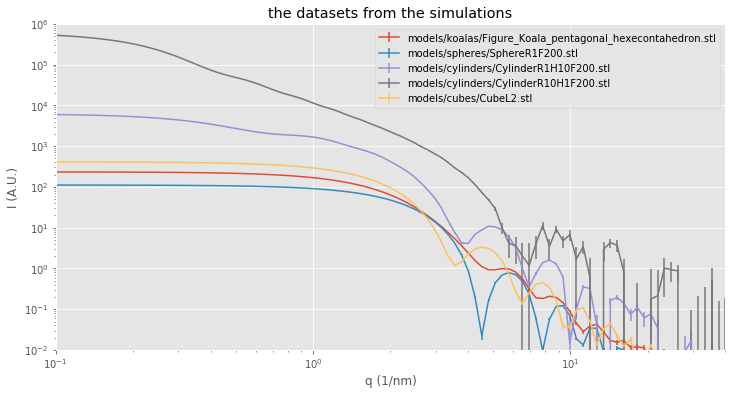

In [ ]:
plt.figure(figsize = [12, 6])
csl = list()
ratio = list()
#for key in Tests[Tests.testgroup == "Martin's Helix"].index.tolist():
for key in Tests.index.tolist():
    
    sponge.simPlot(resultDict[key]["data"], title = Tests.loc[key]["filename"])

plt.title("the datasets from the simulations")
plt.axis("tight")
plt.xlim(.1, 40)
plt.ylim(1e-2, 1e6)

In [19]:
pandas.DataFrame(data=resultDict)


,2,3,4,5,6
data,Q I IError 0 0.1000...,Q I IError 0 0.1000...,Q I IError 0 0.100...,Q I IError 0 0...,Q I IError 0 0.1000...
parameters,testgroup ...,testgroup s...,testgroup ...,testgroup ...,testgroup shapes fi...
